In [ ]:
# Get Darknet
%%bash
git clone https://github.com/pjreddie/darknet
cd /content/darknet/

# Get Dataset
wget https://students.washington.edu/bhimar/frieburg.tar.gz
tar -xzf 'frieburg.tar.gz' -C '/content/darknet'
# Replace data folder with our dataset
rm -rf /content/darknet/data
mv /content/darknet/frieburg /content/darknet/data

touch /content/darknet/cfg/yolov3_custom_test.cfg


Cloning into 'darknet'...
--2020-12-19 00:14:14--  https://students.washington.edu/bhimar/frieburg.tar.gz
Resolving students.washington.edu (students.washington.edu)... 128.208.181.36, 128.95.242.206
Connecting to students.washington.edu (students.washington.edu)|128.208.181.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111261896 (106M) [application/x-gzip]
Saving to: ‘frieburg.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  567K 3m11s
    50K .......... .......... .......... .......... ..........  0%  663K 2m58s
   100K .......... .......... .......... .......... ..........  0% 1.11M 2m30s
   150K .......... .......... .......... .......... ..........  0% 1.20M 2m15s
   200K .......... .......... .......... .......... ..........  0% 1.23M 2m5s
   250K .......... .......... .......... .......... ..........  0% 2.89M 1m50s
   300K .......... .......... .......... .......... ..........  0% 1.14M 1m48s
   350K .......... ........

In [ ]:
# Mount drive for access to weights
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Modify testing configuration file for inference
1. Copy contents from yolov3_custom_train.cfg (from the training notebook, and available in my Github repo) into yolov3_custom_test.cfg. 
2. Uncomment the parameters under "Testing" and comment out the parameters under "Training"

In [ ]:
import numpy as np
import time
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline


# display function to show image on Jupyter
def display_img(img,cmap=None):
    fig = plt.figure(figsize = (12,12))
    plt.axis(False)
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap)

labelsPath = os.path.join("/content/darknet/data/classes.names")
print(labelsPath)
LABELS = open(labelsPath).read().strip().split("\n")

# Using the .backup file means we are using the most trained weights
weightsPath = os.path.join("/content/drive/MyDrive/YOLOv3_weight/backup/yolov3_custom_train.backup")
configPath = os.path.join("/content/darknet/cfg/yolov3_custom_test.cfg")

/content/darknet/data/classes.names


In [ ]:
# Read in the configuration and weights
net = cv2.dnn.readNetFromDarknet(configPath,weightsPath)

In [ ]:
# A util function to predict and display bounding boxes
def predict(image):
    
    # initialize a list of colors to represent each possible class label
    np.random.seed(42)
    COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")
    (H, W) = image.shape[:2]
    
    # determine only the "ouput" layers name which we need from YOLO
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    
    # construct a blob from the input image and then perform a forward pass of the YOLO object detector, 
    # giving us our bounding boxes and associated probabilities
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)
    
    boxes = []
    confidences = []
    classIDs = []
    threshold = 0.2
    
    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability) of
            # the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            # confidence type=float, default=0.5
            if confidence > threshold:
                # scale the bounding box coordinates back relative to the
                # size of the image, keeping in mind that YOLO actually
                # returns the center (x, y)-coordinates of the bounding
                # box followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # use the center (x, y)-coordinates to derive the top and
                # and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates, confidences,
                # and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # apply non-maxima suppression to suppress weak, overlapping bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, threshold, 0.1)

    # ensure at least one detection exists
    if len(idxs) > 0:
        print("object(s) detected")
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            # draw a bounding box rectangle and label on the image
            color = (255,0,0)
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            text = "{}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x +15, y + 20), cv2.FONT_HERSHEY_SIMPLEX,
                1, color, 2)
    return image

/content/darknet
./data/images/CORN0007_png.rf.6ff31986ecca0f1fbb6a6272d64972b5.jpg
object(s) detected
./data/images/TEA0094_png.rf.2cbf6b411b39820b80aee1cf557352ca.jpg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


object(s) detected
./data/images/COFFEE0232_png.rf.f1c429625e7076acd8d5514ceb4944ca.jpg
object(s) detected
./data/images/VINEGAR0042_png.rf.38afd2330eae3ccfe0f0bdab159271a0.jpg
object(s) detected
./data/images/CHOCOLATE0120_png.rf.89ac1f036a413286128c726da072f1de.jpg
object(s) detected
./data/images/SODA0019_png.rf.25ca9536422f7e5d89b14862c5686e3e.jpg
object(s) detected
./data/images/MILK0147_png.rf.4492b201c36289dce3d554ad263af2be.jpg
object(s) detected
./data/images/PASTA0083_png.rf.3bea321e0973793da4fa5a52938b5266.jpg
object(s) detected
./data/images/VINEGAR0069_png.rf.5e430201aa643942df5d2922e2ebaf49.jpg
object(s) detected
./data/images/BEANS0019_png.rf.fec8c31f91a7078dc17820983b407e62.jpg
object(s) detected


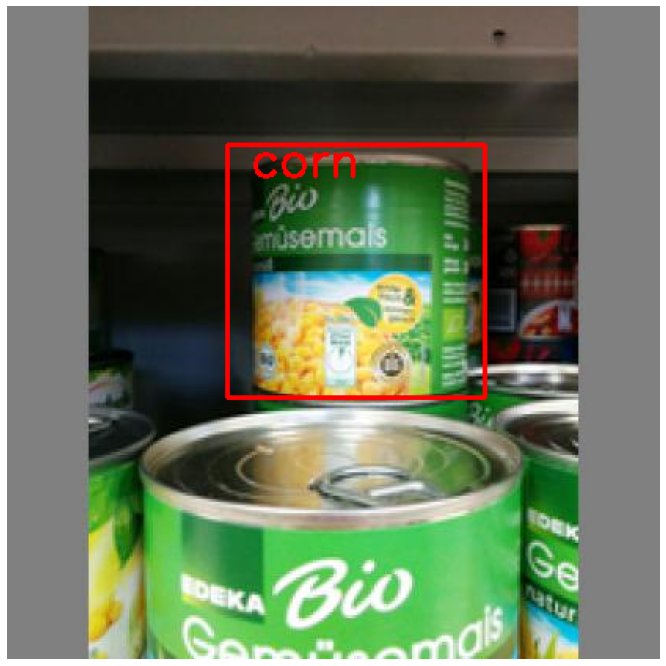

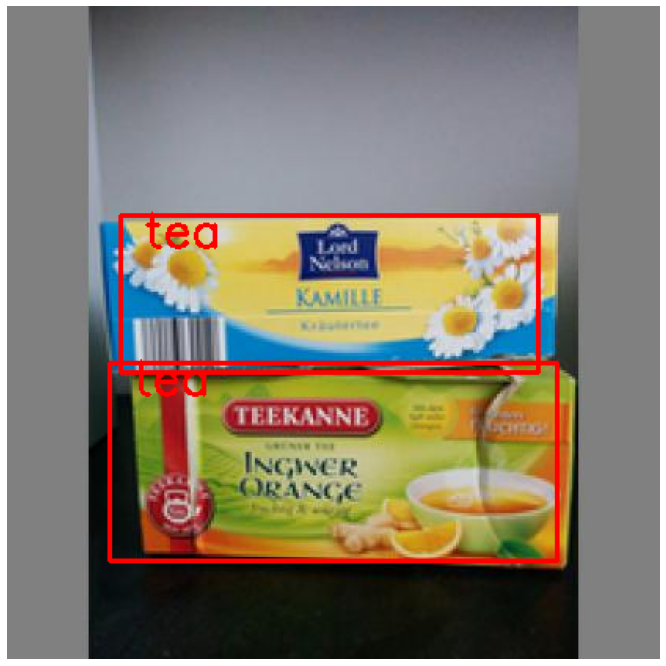

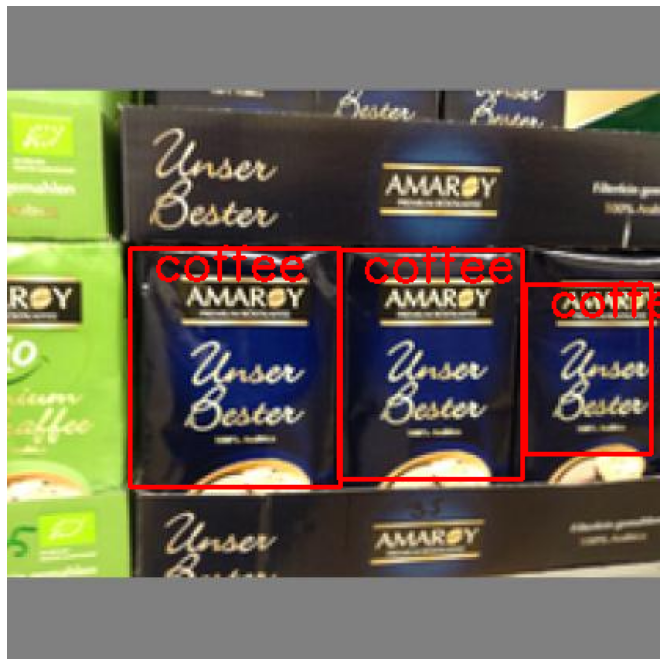

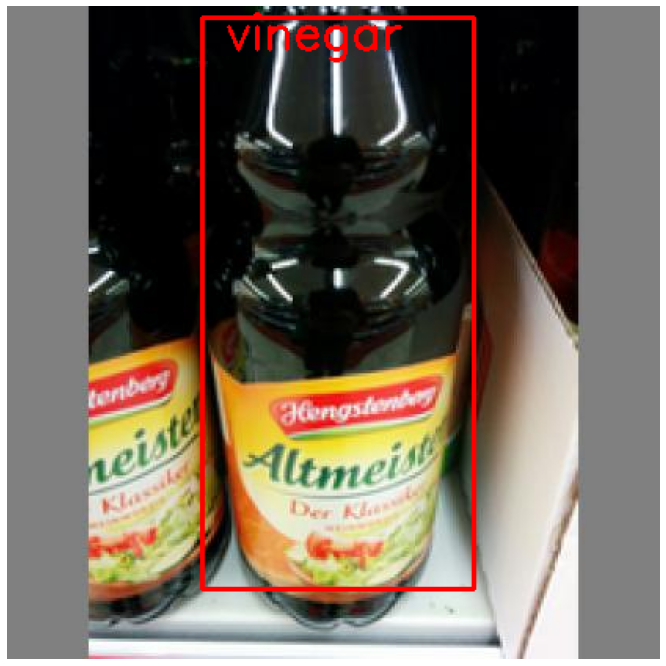

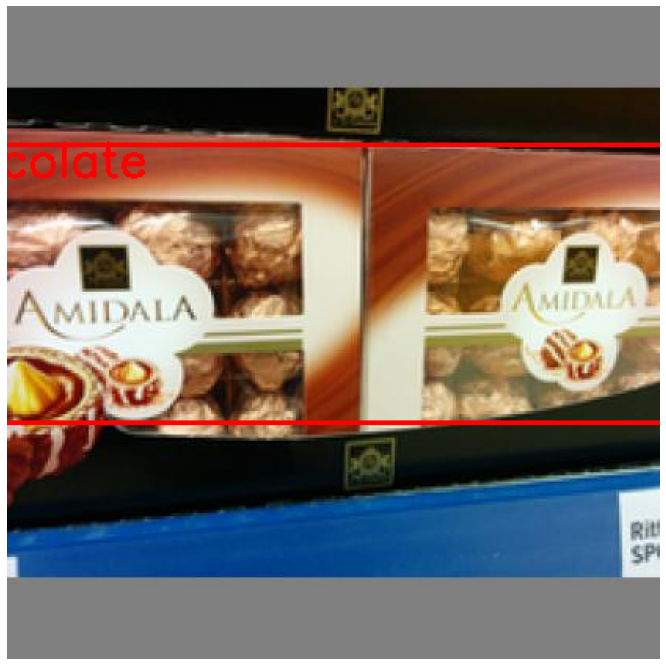

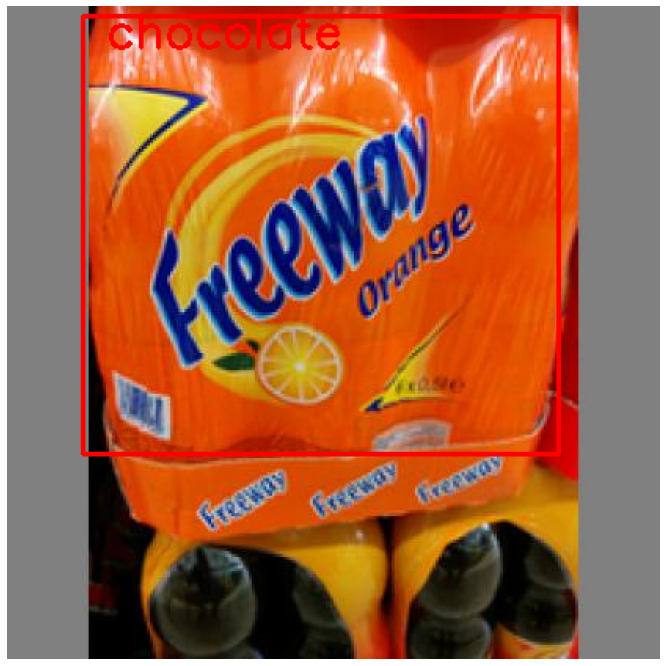

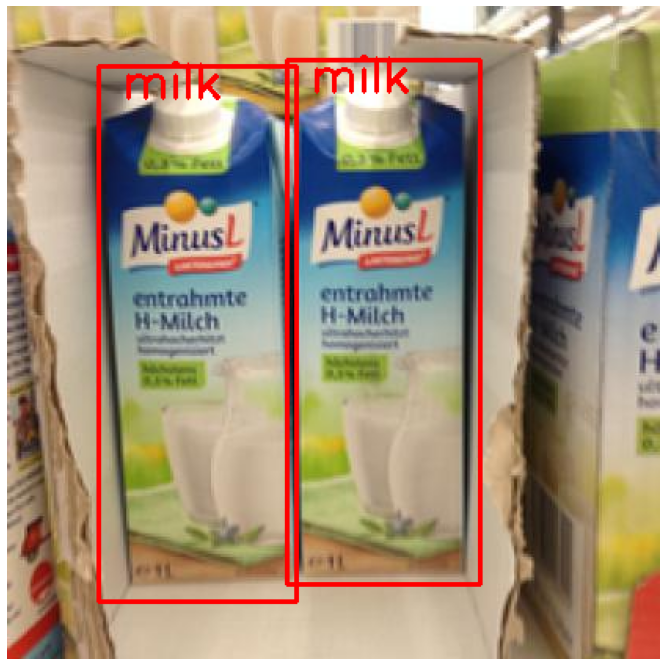

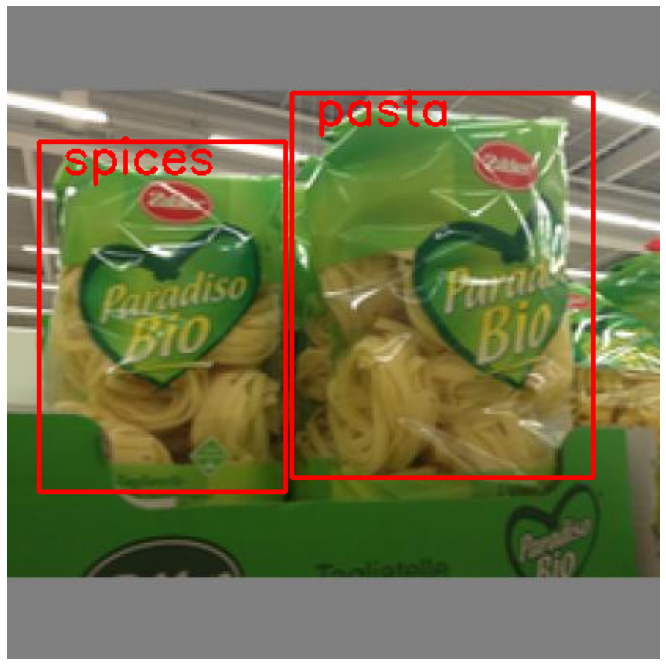

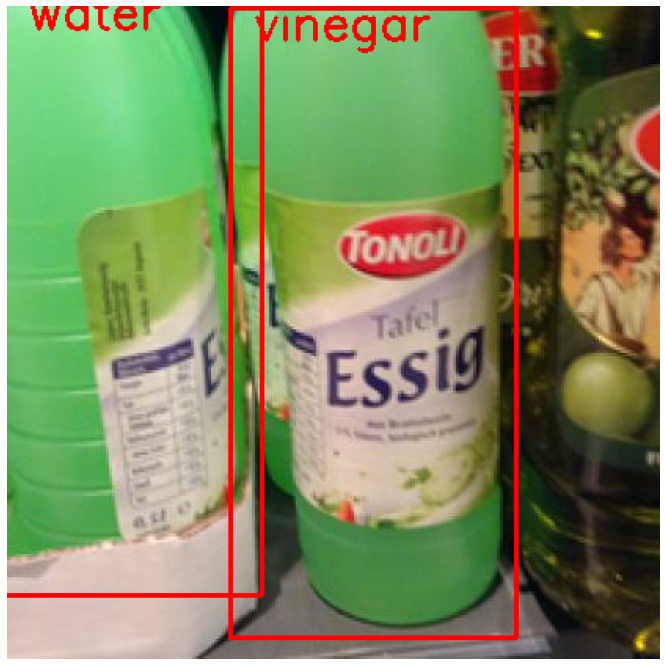

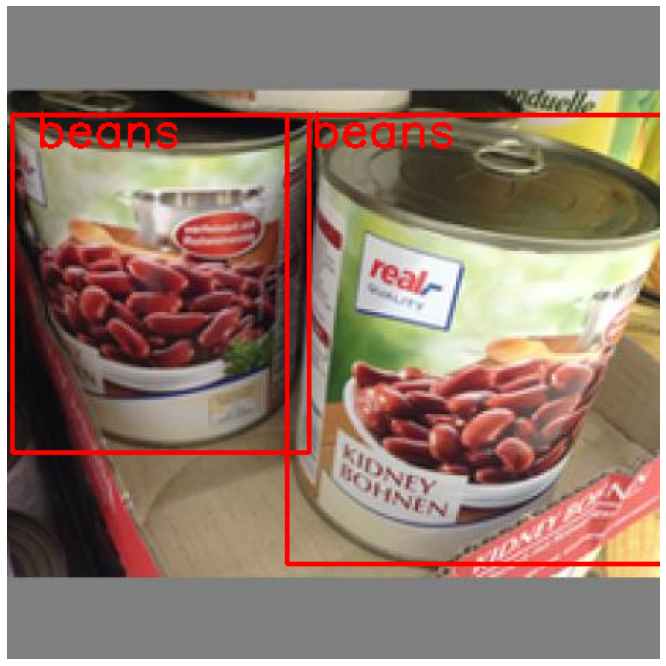

In [ ]:
# Run inference on some random images from the test set to see how we did!

%cd /content/darknet/
import random

with open("/content/darknet/data/valid.txt") as f:
    lines = f.readlines()

# generating 10 image predictions from the test set
for i in range(0,10):
  img_idx = random.randrange(len(lines))
  img_path = lines[img_idx]
  img_path = img_path[:-1]
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  print(img_path)
  display_img(predict(img))


In [ ]:
# Inference in video
# upload video for inference to /content/darknet/

cap =cv2.VideoCapture('food.mp4')

number_frame = 30.0 #higher frames better quality of the video
# may have to adjust for your video!
video_size = (1920,1080)
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('food2.mp4',fourcc, number_frame,video_size)

while True:
    ret,frame = cap.read() 
    
    if ret:
        
        frame = cv2.resize(frame, (1920,1080))
        frame = predict(frame)
        # cv2.imshow("image",frame)
        out.write(frame)

        if cv2.waitKey(1) & 0xff == ord("q"):
            break
    else:
        break
        
cap.release()   
out.release()
cv2.destroyAllWindows()
print("Done!")

object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) detected
object(s) de